## Correcting for "glint"

Some CHEOPS data sets are affected by _glint_ - artefacts caused by scattered light that is not removed by the data reduction pipeline. These are thought to be caused by internal reflections within the telescope structure, e.g., moonlight reflected from the secondary mirror vanes.

To account for glint we can construct a smooth function as a function of the spacecraft roll angle. This can be constructed from the data outside the eclipse or by fitting the residuals from an initial fit to the data. In this notebook we fit the residuals from an initial least-squares fit.


For the specific case of an internal reflection due to moonlight, use `datatset.add_glint(moon=True)` to account for the motion of the Moon during the exposure (not done here). Use `dataset.planet_check()` to determine if the moon or other solar system body is close to the target during the observation.

This notebook demonstrates the correction for glint within `pycheops`  by injecting a simulated glint artefact into a simulated dataset. 

In [1]:
%pylab inline
from pycheops import Dataset, StarProperties
from uncertainties import ufloat

# Temporary(?) fix for problem with coordinate look-up for HD stars in astropy 
from astropy.coordinates.name_resolve import sesame_database
sesame_database.set('simbad');


Populating the interactive namespace from numpy and matplotlib


### Load  dataset
Using the same CHEOPSim simulated dataset as `dataset_fit_eclipse_from_simulation`.

In [2]:
#dataset=Dataset.from_test_data('DP-079', target='HD97658')
dataset = Dataset('CH_PR900048_TG001501_V0000', target='HD97658')
_  = dataset.get_lightcurve(aperture='OPTIMAL')

time, flux, flux_err = dataset.clip_outliers(verbose=True)

Found archive tgzfile /Users/pflm/pycheops/data/CH_PR900048_TG001501_V0000.tgz
 PI name     : CHEOPSim
 OBS ID      : 7649
 Target      : HD97658
 Coordinates : 11:14:33.16 +25:42:37.4
 Spec. type  : K1
 V magnitude : 7.71 +- 0.00
Light curve data loaded from  /Users/pflm/pycheops/data/CH_PR900048_TG001501_V0000-OPTIMAL.fits
Time stored relative to BJD = 2458942
Aperture radius used = 17 arcsec
Light curve corrected for flux from background stars
Mean counts = 97182731.7
Median counts = 97196778.9
RMS counts = 39092.5 [402 ppm]
Median standard error = 10065.7 [104 ppm]
Mean contamination = 0.5 ppm

Rejected 2 points more than 5.0 x MAD = 583 ppm from the median


In [3]:
dataset.planet_check()

BJD = 2458942.6802481995
Body     R.A.         Declination  Sep(deg)
-------------------------------------------
Moon     08:33:47.96  +21:35:04.8      38.3
Mars     20:18:13.78  -20:41:21.1     102.2
Jupiter  19:45:13.48  -21:18:23.9     122.1
Saturn   20:10:58.46  -20:05:51.2     132.7
Uranus   02:11:30.83  +12:45:43.8     121.3
Neptune  23:21:24.90  -05:15:58.1     159.9


### Estimate stellar density and limb darkening from parameters in SWEET-Cat 

Prior on mean stellar density is helpful to constrain the width of the eclipse.

In [4]:
pHD97658 = StarProperties(dataset.target)
print(pHD97658)
logrhoprior = pHD97658.logrho
# logrhoprior = ufloat(0.0593, 0.1556) # for offline user

Identifier : HD97658
Coordinates: 11:14:33.16 +25:42:37.4
T_eff :  5137 +/-  36 K   [SWEET-Cat]
log g :  4.47 +/- 0.09    [SWEET-Cat]
[M/H] : -0.35 +/- 0.02    [SWEET-Cat]
log rho :  0.06 +/- 0.16  (solar units)
h_1 : 0.710 +/- 0.010     [Stagger]
h_2 : 0.439 +/- 0.051     [Stagger]



### Least-squares fit

 

In [5]:
result = dataset.lmfit_transit(P=ufloat(9.489264,0.00001), T_0=ufloat(0.890,0.001),
                               h_1=pHD97658.h_1, h_2=pHD97658.h_2.n, 
                              logrhoprior=logrhoprior)
print(dataset.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 136
    # data points      = 578
    # variables        = 7
    chi-square         = 1376.75106
    reduced chi-square = 2.41112269
    Akaike info crit   = 515.650724
    Bayesian info crit = 546.167741
    RMS residual       = 160.3 ppm
[[Variables]]
    T_0:     0.89064084 +/- 4.3926e-04 (0.05%) (init = 0.89)
    P:       9.48926400 +/- 1.5528e-05 (0.00%) (init = 9.489264)
    D:       7.4785e-04 +/- 6.3200e-05 (8.45%) (init = 0.001223372)
    W:       0.01428649 +/- 1.4631e-04 (1.02%) (init = 0.02208278)
    b:       0.42987485 +/- 0.29440316 (68.49%) (init = 0.5)
    f_c:     0 (fixed)
    f_s:     0 (fixed)
    h_1:     0.70077856 +/- 0.01455575 (2.08%) (init = 0.71)
    h_2:     0.439 (fixed)
    c:       1.00009612 +/- 8.0981e-06 (0.00%) (init = 1)
    k:       0.02734683 +/- 0.00115553 (4.23%) == 'sqrt(D)'
    aR:      20.7896005 +/- 3.18195430 (15.31%) == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:    0.999

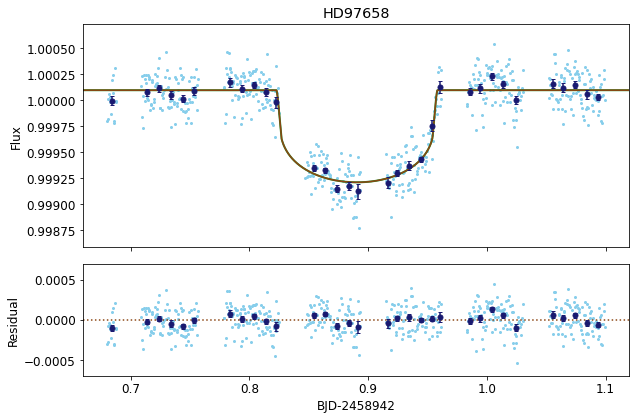

In [6]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12)

### Injection of a simulated glint artefact

Glint artefacts tend to show a peak with a dip either side caused by the scattered light perturbing the background flux estimate. Approximate this with a sinc function.

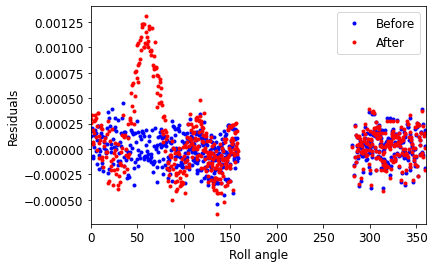

In [7]:
A_glint = 140 ## Amplitude of glint artefact in ppm
angle = np.array(dataset.lc['roll_angle'])
flux = np.array(dataset.lc['flux'])
fit = dataset.lmfit.bestfit
res = flux - fit
plt.plot(angle,res,'b.',label='Before')

phi = (angle-60)*np.pi/180
gfunc = A_glint*1e-6*sin(8*phi)/phi
flux = flux + gfunc
res = flux - fit
plt.plot(angle,res,'r.',label='After')
plt.xlabel('Roll angle')
plt.ylabel('Residuals')
plt.legend()
plt.xlim(0,360)
dataset.lc['flux'] = flux

### Fit to residuals


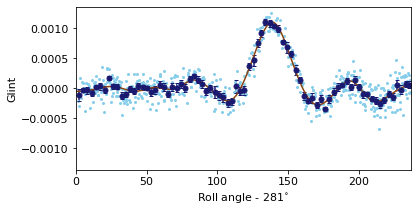

In [8]:
result = dataset.lmfit_transit(P=ufloat(9.489264,0.00001), T_0=ufloat(0.890,0.001),
                               h_1=pHD97658.h_1, h_2=pHD97658.h_2.n,
                              logrhoprior=logrhoprior) 
glint = dataset.add_glint(16, binwidth=3)

### Least squares fit including glint model

In [9]:
result = dataset.lmfit_transit(P=ufloat(9.489264,0.00001), T_0=ufloat(0.890,0.001),
                               h_1=pHD97658.h_1, h_2=pHD97658.h_2.n,
                              logrhoprior=logrhoprior, glint_scale=(0,2)) 
print(dataset.lmfit_report())


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 148
    # data points      = 578
    # variables        = 8
    chi-square         = 1259.37701
    reduced chi-square = 2.20943335
    Akaike info crit   = 466.145575
    Bayesian info crit = 501.022166
    RMS residual       = 153.3 ppm
[[Variables]]
    T_0:          0.89003062 +/- 3.6802e-04 (0.04%) (init = 0.89)
    P:            9.48926400 +/- 1.4864e-05 (0.00%) (init = 9.489264)
    D:            7.3311e-04 +/- 5.9483e-05 (8.11%) (init = 0.001224733)
    W:            0.01415582 +/- 1.2664e-04 (0.89%) (init = 0.02208278)
    b:            0.28129202 +/- 0.49125447 (174.64%) (init = 0.5)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    h_1:          0.70507343 +/- 0.01387858 (1.97%) (init = 0.71)
    h_2:          0.439 (fixed)
    c:            1.00012735 +/- 7.7810e-06 (0.00%) (init = 1)
    glint_scale:  1.01779609 +/- 0.02283858 (2.24%) (init = 1)
    k:            0.02707602 +/- 0.0010984

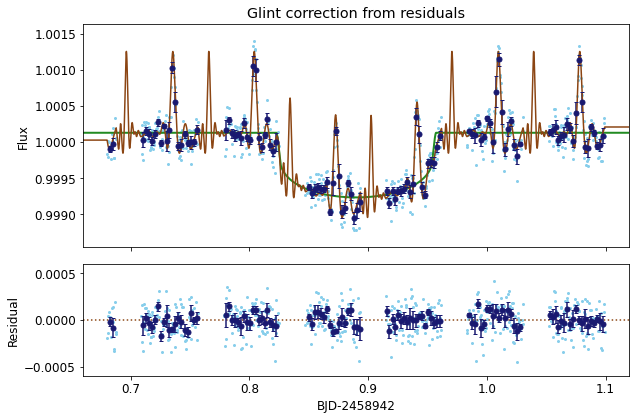

In [10]:
fig = dataset.plot_lmfit(title='Glint correction from residuals',
                         figsize=(9,6),fontsize=12,binwidth=0.0025)

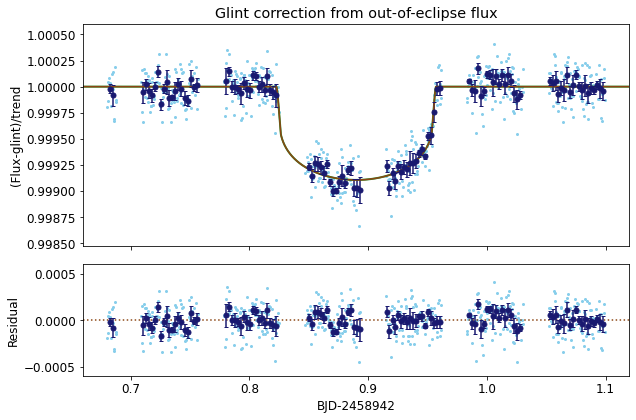

In [11]:
fig = dataset.plot_lmfit(title='Glint correction from out-of-eclipse flux',
                         figsize=(9,6),fontsize=12,binwidth=0.0025,detrend=True)


### Sampling the posterior
Sampling the posterior probability distribution using the affine-invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/). 

The $\pm$1-sigma limits on parameters from the prior are indicated in the corner plot using dashed lines.

This return value from emcee_transit is an instance of an [EnsembleSampler](https://emcee.readthedocs.io/en/latest/user/sampler/) object.

In [12]:
sampler = dataset.emcee_sampler()
print(dataset.emcee_report(min_correl=0.5))

Running burn-in ..


100%|██████████| 256/256 [01:42<00:00,  2.49it/s]

Running sampler ..



100%|██████████| 128/128 [00:53<00:00,  2.41it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 8192
    # data points      = 574
    # variables        = 9
    chi-square         = 1259.83443
    reduced chi-square = 2.22979545
    Akaike info crit   = -8449.90994
    Bayesian info crit = -8410.73627
    RMS residual       = 153.4 ppm
[[Variables]]
    T_0:          0.89019003 +/- 4.9587e-04 (0.06%) (init = 0.89)
    P:            9.48926595 +/- 1.0967e-05 (0.00%) (init = 9.489264)
    D:            7.4616e-04 +/- 3.4061e-05 (4.56%) (init = 0.001224733)
    W:            0.01415421 +/- 1.1413e-04 (0.81%) (init = 0.02208278)
    b:            0.36317164 +/- 0.21654104 (59.62%) (init = 0.5)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    h_1:          0.70772173 +/- 0.00929894 (1.31%) (init = 0.71)
    h_2:          0.439 (fixed)
    c:            1.00012798 +/- 8.1738e-06 (0.00%) (init = 1)
    glint_scale:  1.01970770 +/- 0.02329369 (2.28%) (init = 1)
    k:            0.02731588 +/- 0.0010984

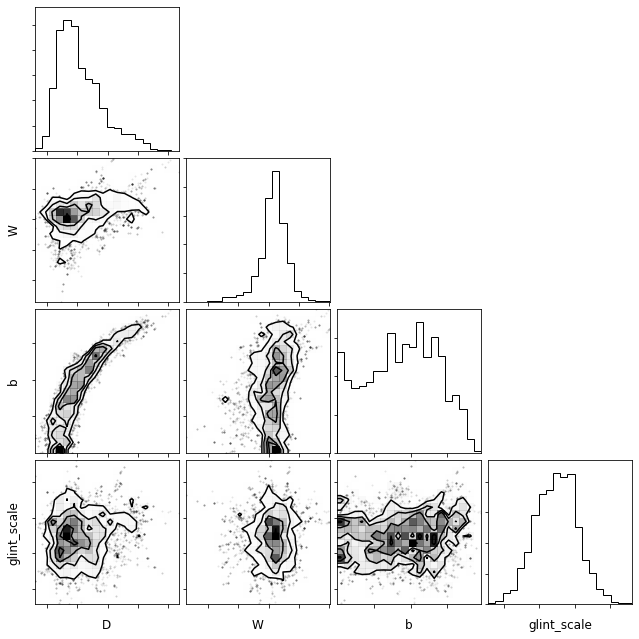

In [13]:
cornerplot = dataset.corner_plot(['D','W','b','glint_scale'])

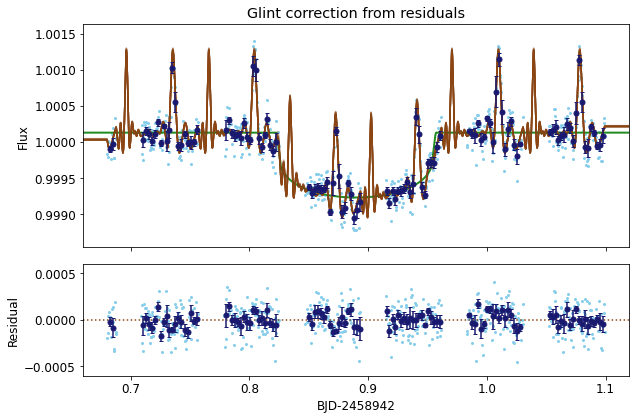

In [14]:
fig = dataset.plot_emcee(title='Glint correction from residuals',
                         figsize=(9,6),fontsize=12, binwidth=0.0025)

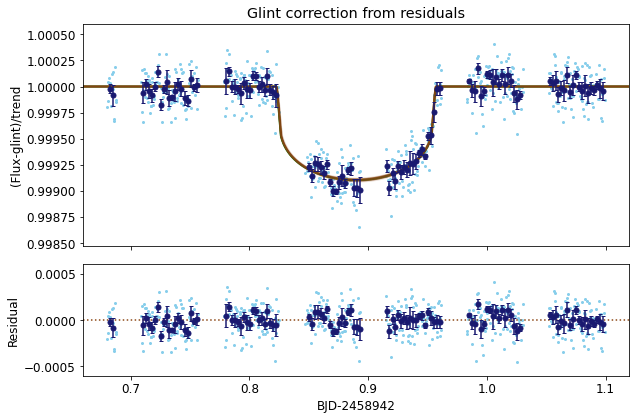

In [15]:
fig = dataset.plot_emcee(title='Glint correction from residuals', detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.0025)

### Add correlated noise

Now use "add_shoterm=True" so that correlated noise is modelled using the SHOTerm kernel from [celerite](https://celerite.readthedocs.io/en/stable/).

Broad priors on log_sigma, log_omega0 and log_S0 from a previous run of this sampler without priors are used here to remove long tails in the distrubtions with very few samples  that mess up the plots.

In [16]:
sampler = dataset.emcee_sampler(add_shoterm=True,  
                                log_sigma=(-11,-7), log_omega0=(3.5,7.5), log_S0=(-30,-20))
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 256/256 [01:57<00:00,  2.18it/s]

Running sampler ..



100%|██████████| 128/128 [00:52<00:00,  2.42it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 8192
    # data points      = 574
    # variables        = 11
    chi-square         = 1262.09713
    reduced chi-square = 2.24173558
    Akaike info crit   = -8449.55559
    Bayesian info crit = -8401.67667
    RMS residual       = 153.5 ppm
[[Variables]]
    T_0:          0.89018569 +/- 5.2255e-04 (0.06%) (init = 0.89)
    P:            9.48926503 +/- 1.0431e-05 (0.00%) (init = 9.489264)
    D:            7.5097e-04 +/- 4.1863e-05 (5.57%) (init = 0.001224733)
    W:            0.01413828 +/- 1.2870e-04 (0.91%) (init = 0.02208278)
    b:            0.39053521 +/- 0.22683115 (58.08%) (init = 0.5)
    f_c:          0 (fixed)
    f_s:          0 (fixed)
    h_1:          0.70760451 +/- 0.01077537 (1.52%) (init = 0.71)
    h_2:          0.439 (fixed)
    c:            1.00012467 +/- 9.7094e-06 (0.00%) (init = 1)
    glint_scale:  1.01528532 +/- 0.02624729 (2.59%) (init = 1)
    k:            0.02740377 +/- 0.001098

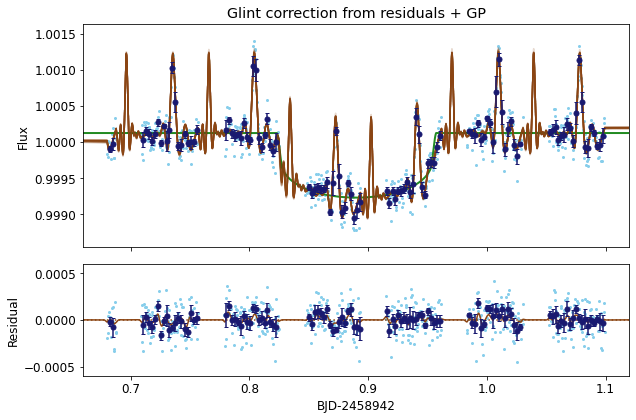

In [17]:
fig = dataset.plot_emcee(title='Glint correction from residuals + GP',
                         figsize=(9,6),fontsize=12, binwidth=0.0025)

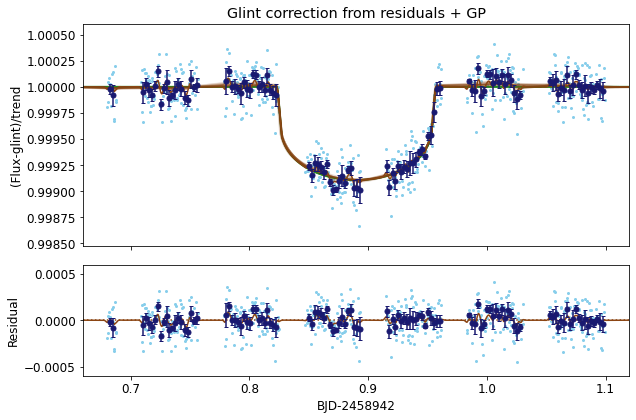

In [18]:
fig = dataset.plot_emcee(title='Glint correction from residuals + GP', detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.0025,)

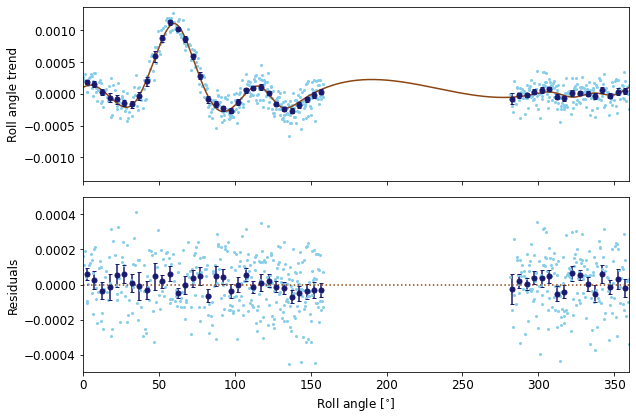

In [19]:
fig = dataset.rollangle_plot(figsize=(9,6),fontsize=12,binwidth=5)

&copy; Pierre Maxted, Keele University 2020